## Load NASBench library and dataset

In [2]:
from nasbench import api
nasbench = api.NASBench('/mnt/workspace/DATASET/NASBench-101/nasbench_only108.tfrecord')

Loading dataset from file... This may take a few minutes...
Loaded dataset in 34 seconds


In [ ]:
import wandb
wandb.init(project="nas", entity="jojo23333")

In [ ]:
# Standard imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import random

# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix

## API Data explore

In [ ]:
# Sample Query an Inception-like cell from the dataset.
cell = api.ModelSpec(
  matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
          [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
          [0, 0, 0, 0, 0, 1, 0],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 0]],   # output layer
  # Operations at the vertices of the module, matches order of matrix.
  ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])

# Querying multiple times may yield different results. Each cell is evaluated 3
# times at each epoch budget and querying will sample one randomly.
data = nasbench.query(cell)
for k, v in data.items():
  print('%s: %s' % (k, str(v)))

module_adjacency: [[0 1 1 1 1 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]]
module_operations: ['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'maxpool3x3', 'output']
trainable_parameters: 3354926
training_time: 1433.7239990234375
train_accuracy: 0.9998998641967773
validation_accuracy: 0.9265825152397156
test_accuracy: 0.9222756624221802


In [ ]:
from map_elites import dfs

In [51]:
from tqdm import tqdm
cnt = 0
nr = []
maxl = []
minl = []
param = []
for i in tqdm(nasbench.hash_iterator()):
    x, y = nasbench.get_metrics_from_hash(i)
    param.append(x['trainable_parameters'])
#     print(a)
#     print(b)
    a, b, c = dfs(x['module_adjacency'], 0, 0, 0, 10)
    nr.append(a)
    maxl.append(b)
    minl.append(c)

100%|██████████| 423624/423624 [00:18<00:00, 22341.77it/s]


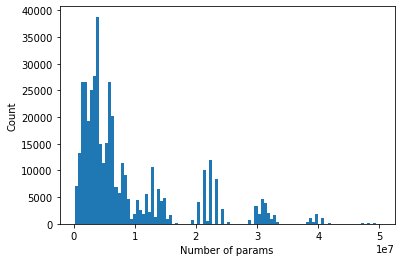

In [55]:
plt.hist(param, bins=100)
plt.xlabel("Number of params")
plt.ylabel("Count")
plt.show()

In [56]:
sorted_param = sorted(param)

In [88]:
[sorted_param[i * len(sorted_param)//4] for i in range(1, 4)] + [sorted_param[-1]]

[2906692, 5356682, 10880650, 49979274]

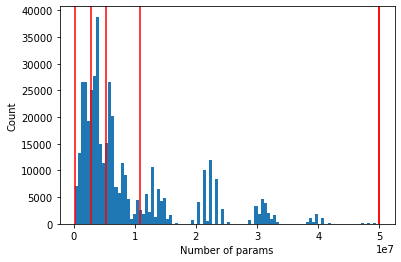

In [90]:
plt.hist(param, bins=100)
plt.xlabel("Number of params")
plt.ylabel("Count")
for x in [227274, 2906692, 5356682, 10880650, 49979274]:
    plt.axvline(x=x, color='r')
plt.show()

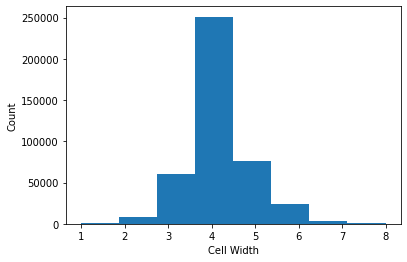

In [13]:
plt.hist(nr, bins=8)
plt.xlabel("Cell Width")
plt.ylabel("Count")
plt.show()

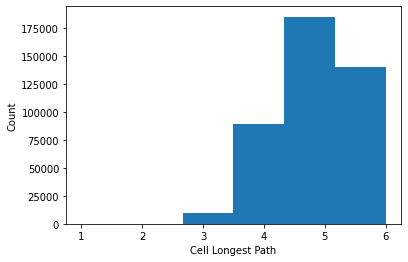

In [14]:
plt.hist(maxl, bins=6)
plt.xlabel("Cell Longest Path")
plt.ylabel("Count")
plt.show()

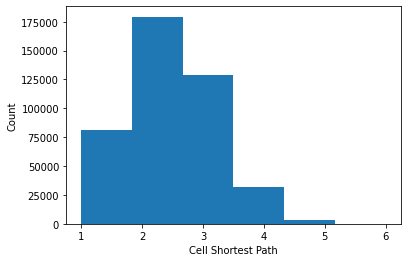

In [15]:
plt.hist(minl, bins=6)
plt.xlabel("Cell Shortest Path")
plt.ylabel("Count")
plt.show()

## Random search vs Evolution vs Genetic Algorithms

In [16]:
from tqdm import tqdm
from time import time

Elite Matrix DIM: (5, 8, 6, 6)


In [78]:
MAX_N = 6
MAX_R = 8 
MAX_L = 6
MAX_S = 6
NASBENCH_DIM = (MAX_N, MAX_R, MAX_L, MAX_S)

def get_nasbench_elites_3d(adj, module):
    num_routes, max_len, min_len = dfs(adj, 0, 0, 0, 10)
    num_node = len(module) 
    # num_routes 1~8
    # max_len 1~6
    # min_len 1~6
    return num_routes - 1, max_len - 1, min_len - 1

def get_nasbench_elites(adj, module):
    num_routes, max_len, min_len = dfs(adj, 0, 0, 0, 10)
    num_node = len(module) 
    # num_node 2~7
    # num_routes 1~8
    # max_len 1~6
    # min_len 1~6
    return num_node - 2, num_routes - 1, max_len - 1, min_len - 1

NASBENCH_PARAM_DIST = [2906692, 5356682, 10880650, 50000000]
def get_nasbench_elites_params(elite):
    adj = elite["module_adjacency"]
    modules = elite["module_operations"]
    num_param = elite["trainable_parameters"]
    num_routes, max_len, min_len = dfs(adj, 0, 0, 0, 10)
    for i in range(len(NASBENCH_PARAM_DIST)):
        if num_param < NASBENCH_PARAM_DIST[i]:
            param_num_level = i
            return param_num_level, num_routes - 1, max_len - 1, min_len - 1

class EliteMatrix:
    """
    A class for saving qulity diversity policies, capable of handling different dim size
    """
    def __init__(self, dims, elites=None, get_idx_fn=get_nasbench_elites_3d):
        self.dims = dims
        self.get_idx_fn = get_idx_fn
        if elites is None:
            self.elites = np.full(dims, None)
        else:
            self.elites = elites
    
    def update_elites(self, elite):
        idx = self.get_idx_fn(elite)
        cur_elite = self.elites[idx]
        if cur_elite is None:
            self.elites[idx] = copy.deepcopy(elite)
        elif cur_elite['validation_accuracy'] < elite['validation_accuracy']:
            self.elites[idx] = copy.deepcopy(elite)
            
    def get_performance(self, key='validation_accuracy'):
        fn = lambda x: x[key] if x is not None and key in x else 0 
        return np.array([fn(x) for x in self.elites.flatten()]).reshape(self.dims)
    
    def iter(self):
        for idx, x in np.ndenumerate(self.elites):
            if self.elites[idx] is not None:
                yield self.elites[idx], idx
    
    def update_metric(self, metric, idx, key='new_metric'):
        assert self.elites[idx] is not None
        self.elites[idx][key] = metric
    
    @classmethod
    def load(cls, x):
        elites = np.load(x, allow_pickle=True)
        dims = elites.shape
        return cls(dims, elites)

    def save(self, path):
        np.save(path, self.elites)

print(f"Elite Matrix DIM: {NASBENCH_DIM}")
gt_elites_matrix = EliteMatrix((5,8,6,6), get_idx_fn=get_nasbench_elites_params)

Elite Matrix DIM: (6, 8, 6, 6)


In [79]:
for i in tqdm(nasbench.hash_iterator()):
    x, y = nasbench.get_metrics_from_hash(i)
    y = y[108]
    averaged_y = {}
    for k in y[0].keys():
        averaged_y[k] = np.mean([x[k] for x in y])
    x.update(averaged_y)
    x['validation_accuracy'] = x['final_validation_accuracy']
    x['test_accuracy'] = x['final_test_accuracy']
    gt_elites_matrix.update_elites(x)


100%|██████████| 423624/423624 [00:51<00:00, 8271.89it/s]


In [85]:
np.save('nasbench_gt_elites_PRLS.npy', gt_elites_matrix.elites)

In [87]:
cnt = 0
for x in gt_elites_matrix.iter():
    cnt = cnt + 1
print(cnt)

424


In [171]:
a = np.load("nasbench_gt_KMNIST.npy", allow_pickle=True)

(8, 6, 6)

In [ ]:

plot_3d_in_2d(c.elites_matrix.get_performance())

In [172]:
gt_elites_matrix.elites[0][0][0]

{'module_adjacency': array([[0, 1],
        [0, 0]], dtype=int8),
 'module_operations': ['input', 'output'],
 'trainable_parameters': 882570,
 'halfway_training_time': 142.21833292643228,
 'halfway_train_accuracy': 0.7120392521222433,
 'halfway_validation_accuracy': 0.6670339107513428,
 'halfway_test_accuracy': 0.6697048544883728,
 'final_training_time': 284.5003356933594,
 'final_train_accuracy': 0.9782652258872986,
 'final_validation_accuracy': 0.8340344627698263,
 'final_test_accuracy': 0.837707002957662,
 'validation_accuracy': 0.8340344627698263,
 'test_accuracy': 0.837707002957662}

In [131]:

class SimpleGAController:
    def __init__(self, num_population=1001, num_individual=20, sigma=0.02) -> None:
        self.num_pop = num_population
        self.num_top_ind = num_individual
        self.sigma = sigma
    
        self.population = None
        self.elite = None
        self.fitness = []
        self.elites_matrix = EliteMatrix(MAX_R, MAX_L, MAX_S)

    def create_population(self):
        """
        Creates the initial population of the genetic algorithm as a list of networks' weights (i.e. solutions). Each element in the list holds a different weights of the PyTorch model.
        The method returns a list holding the weights of all solutions.
        """
        initial_spec = random_spec()
        spec_population = [initial_spec]
        for idx in range(self.num_pop-1):
            spec_population.append(mutate_spec(initial_spec))
        return spec_population

    def eval_population(self, population, num_runs=1):
        pop_with_fitness = []
        for p in population:
            # TODO here
            f = {
                "module_adjacency": 0,
                "module_operations": 0, 
                "validation_accuracy": 0,
                "test_accuracy": 0,
                'training_time': 0
            }
            for i in range(num_runs):
                f_i =  self.get_fitness(spec=p)
                f["validation_accuracy"] += f_i["validation_accuracy"]
                f["test_accuracy"] += f_i["test_accuracy"]
                f["training_time"] += f_i["training_time"]
            f = {k: v/num_runs for k, v in f.items()}
            f["module_adjacency"] = f_i["module_adjacency"]
            f["module_operations"] = f_i["module_operations"]
            pop_with_fitness.append((p, f))
        pop_with_fitness = sorted(pop_with_fitness, key=lambda x:-x[1]['validation_accuracy'])
        return pop_with_fitness

    def get_fitness(self, spec):
        data = nasbench.query(spec)
        time_spent, _ = nasbench.get_budget_counters()
        # data['time_spent'] = time_spent
        return data

    def evolve(self, num_generations, log=False):
        best_val_acc = 0
        best_test_acc = 0
        for g in range(num_generations):
            starttime = time()
            if g == 0:
                next_generations = self.create_population()
            else:
                next_generations = []
                for i in range(self.num_pop-1):
                    k = np.random.choice(range(self.num_top_ind))
                    next_generations.append(mutate_spec(self.population[k]))
            evaled_population = self.eval_population(next_generations)
            
            if g == 0:
                self.elite_candidates = [x[0] for x in evaled_population[:10]]
            else:
                self.elite_candidates = [x[0] for x in evaled_population[:9]] + [self.elite[0]]

            elites = self.eval_population(self.elite_candidates, num_runs=10)
            
            for e in evaled_population:
                self.elites_matrix.update_elites(e[1])

            self.elite = elites[0]
            if self.population is not None:
                del self.population
            self.population = [x[0] for x in evaled_population]

            if log:
                hist = np.histogram(
                    a = [x[1]["validation_accuracy"] for x in elites],
                    bins = 10,
                    range = (0.8, 1),
                )
                wandb.log({
                    'elite_val': elites[0][1]['validation_accuracy'],
                    'elite_test': elites[0][1]['test_accuracy'],
                    'pop_histogram': wandb.Histogram(np_histogram=hist)
                })
            if elites[0][1]['validation_accuracy'] > best_val_acc:
                best_val_acc = elites[0][1]['validation_accuracy']
                best_test_acc = elites[0][1]['test_accuracy']
            endtime = time()
            if log:
                print(
                    f"Generation {g} Finished, {(endtime - starttime):.2f}s\n Elite score: {elites[0][1]['test_accuracy']}")

        return self.elite, best_val_acc, best_test_acc


In [132]:
c = SimpleGAController(num_population=160, num_individual=5)
c.evolve(num_generations=100)

((<nasbench.lib.model_spec.ModelSpec at 0x7f4d6ebebac0>,
  {'module_adjacency': array([[0, 1, 1, 1, 1, 1],
          [0, 0, 0, 0, 1, 0],
          [0, 0, 0, 1, 0, 0],
          [0, 0, 0, 0, 1, 0],
          [0, 0, 0, 0, 0, 1],
          [0, 0, 0, 0, 0, 0]], dtype=int8),
   'module_operations': ['input',
    'conv1x1-bn-relu',
    'conv3x3-bn-relu',
    'conv3x3-bn-relu',
    'conv1x1-bn-relu',
    'output'],
   'validation_accuracy': 0.9485577046871185,
   'test_accuracy': 0.9407552003860473,
   'training_time': 3434.397216796875}),
 0.9504707634449006,
 0.9425079941749572)

In [83]:
def plot_3d_in_2d(matrix):
    """Plot 3d matrix in a 2d plane

    Args:
        matrix (np.ndarray): [description]
    """
    from mpl_toolkits.axes_grid1 import AxesGrid
    min_value = np.min(matrix[matrix!=0])
    num_ax = matrix.shape[0]
    fig = plt.figure(dpi=200)
    grid = AxesGrid(fig, 111,
                nrows_ncols=(1, num_ax),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )
    for i, ax in enumerate(grid):
        im = ax.imshow(matrix[i], vmin=min_value-0.05, vmax=matrix.max(), cmap='plasma')
    grid.cbar_axes[0].colorbar(im)
    # for cax in grid.cbar_axes:
    #     cax.toggle_label(False)
    plt.show()

def plot_4d_in_2d(matrix):
    """Plot 3d matrix in a 2d plane

    Args:
        matrix (np.ndarray): [description]
    """
    from mpl_toolkits.axes_grid1 import AxesGrid
    min_value = np.min(matrix[matrix!=0])
    num_ax_1 = matrix.shape[0]
    num_ax_2 = matrix.shape[1]
    fig = plt.figure(dpi=200)
    grid = AxesGrid(fig, 111,
                nrows_ncols=(num_ax_1, num_ax_2),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )
    for i, ax in enumerate(grid):
        j = i % num_ax_2
        i = i // num_ax_2
        im = ax.imshow(matrix[i, j], vmin=min_value-0.05, vmax=matrix.max(), cmap='plasma')
    grid.cbar_axes[0].colorbar(im)
    # for cax in grid.cbar_axes:
    #     cax.toggle_label(False)
    plt.show()

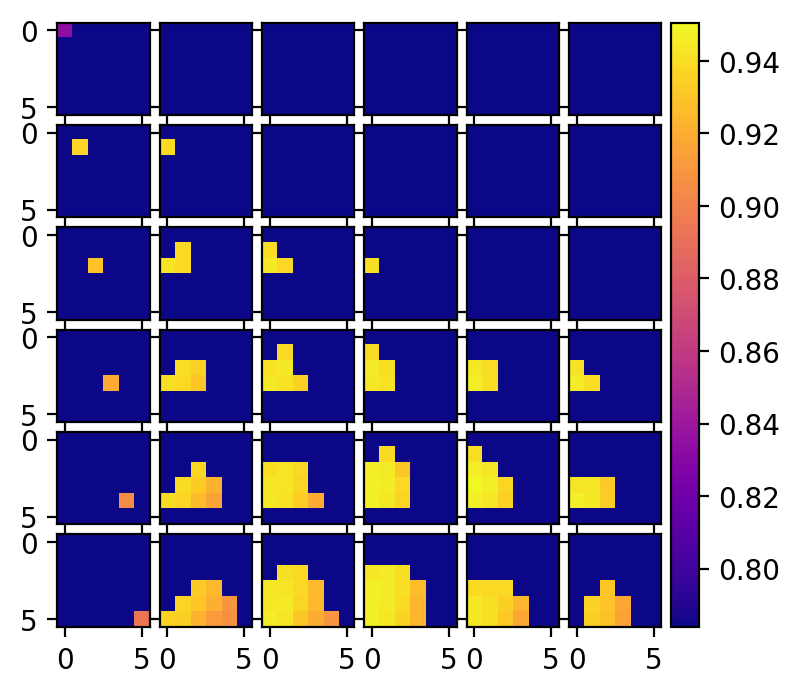

In [50]:
plot_4d_in_2d(gt_elites_matrix.get_performance())

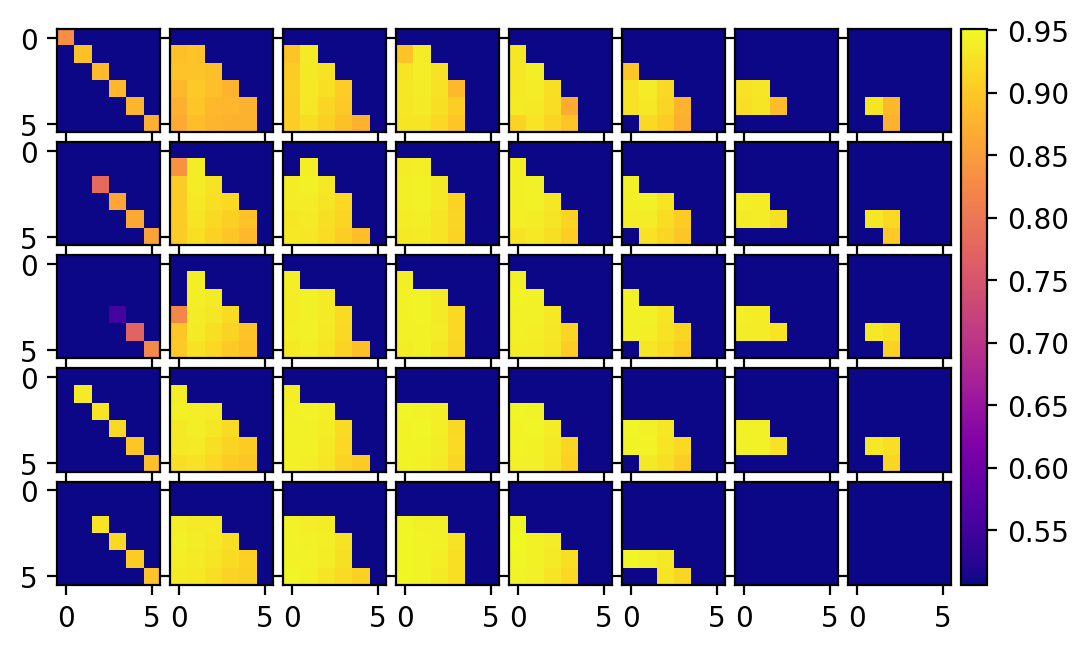

In [84]:
plot_4d_in_2d(gt_elites_matrix.get_performance())

In [82]:
gt_elites_matrix.get_performance().shape

(5, 8, 6, 6)

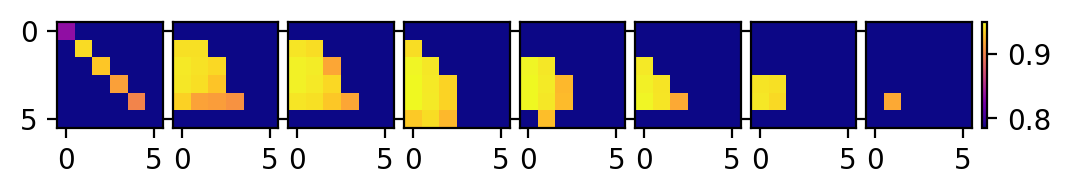

In [149]:
plot_3d_in_2d(c.elites_matrix.get_performance())

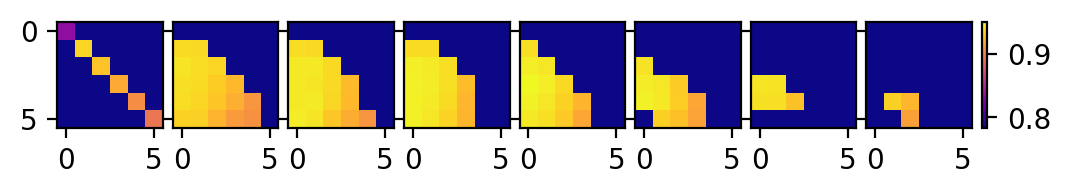

In [162]:
plot_3d_in_2d(gt_elites_matrix.get_performance())

In [98]:
def run_ga(num_pop, num_gen, num_ind, time_repeat=20):
    c = SimpleGAController(num_population=num_pop, num_individual=num_ind)
    ga_data = []
    for i in range(time_repeat):
        e, v, t = c.evolve(num_generations=num_gen)
        ga_data.append((e, v, t))
    mean_best_validation_ga = mean([x[1] for x in ga_data])
    mean_best_test_ga = mean([x[2] for x in ga_data])
    return mean_best_validation_ga, mean_best_test_ga

In [83]:
def run_search(num_ind, time_repeat):
    X=[]
    Y=[]
    Z=[]
#     budgets = [500, 1000, 2000, 4000, 6000, 10000, 20000]
    gens = [10, 20, 30, 40, 50, 60, 80, 90, 100]
    pops = [5, 10, 20, 40, 80, 160, 320]
    for b in tqdm(pops):
        X.append(gens)
        Y.append(b)
        Z.append([
            run_ga(
                num_pop=b+1,
                num_gen=x,
                num_ind=num_ind,
                time_repeat=time_repeat
            )
            for x in gens
        ])
    return X, Y, Z

In [84]:
x, y, z = run_search(num_ind=5, time_repeat=10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [17:42<00:00, 151.79s/it]


In [85]:
x, y, z = np.array(x), np.array(y), np.array(z)

In [92]:
y

array([[  5,  10,  20,  40,  80, 160, 320],
       [  5,  10,  20,  40,  80, 160, 320],
       [  5,  10,  20,  40,  80, 160, 320],
       [  5,  10,  20,  40,  80, 160, 320],
       [  5,  10,  20,  40,  80, 160, 320],
       [  5,  10,  20,  40,  80, 160, 320],
       [  5,  10,  20,  40,  80, 160, 320]])

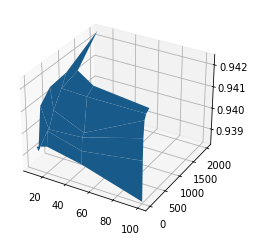

In [73]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Plot a basic wireframe.
ax.plot_wireframe(x, y, z[:,:,1], rstride=1, cstride=1)

plt.show()

In [54]:
c = SimpleGAController(num_population=101, num_individual=5)
ga_data = []
for i in tqdm(range(20)):
    e, v, t = c.evolve(num_generations=50)
    ga_data.append((e, v, t))
mean_best_validation_ga = mean([x[1] for x in ga_data])
print(mean_best_validation_ga)
mean_best_test_ga = mean([x[2] for x in ga_data])
print(mean_best_test_ga)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.54s/it]

0.9483047944307328
0.9407526999711993


In [24]:
# Run random search and evolution search 10 times each. This should take a few
# minutes to run. Note that each run would have taken days of compute to
# actually train and evaluate if the dataset were not precomputed.
random_data = []
evolution_data = []
for repeat in range(100):
  print('Running repeat %d' % (repeat + 1))
  times, best_valid, best_test = run_random_search()
  random_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_evolution_search()
  evolution_data.append((times, best_valid, best_test))

Running repeat 1
Running repeat 2
Running repeat 3
Running repeat 4
Running repeat 5
Running repeat 6
Running repeat 7
Running repeat 8
Running repeat 9
Running repeat 10
Running repeat 11
Running repeat 12
Running repeat 13
Running repeat 14
Running repeat 15
Running repeat 16
Running repeat 17
Running repeat 18
Running repeat 19
Running repeat 20
Running repeat 21
Running repeat 22
Running repeat 23
Running repeat 24
Running repeat 25
Running repeat 26
Running repeat 27
Running repeat 28
Running repeat 29
Running repeat 30
Running repeat 31
Running repeat 32
Running repeat 33
Running repeat 34
Running repeat 35
Running repeat 36
Running repeat 37
Running repeat 38
Running repeat 39
Running repeat 40
Running repeat 41
Running repeat 42
Running repeat 43
Running repeat 44
Running repeat 45
Running repeat 46
Running repeat 47
Running repeat 48
Running repeat 49
Running repeat 50
Running repeat 51
Running repeat 52
Running repeat 53
Running repeat 54
Running repeat 55
Running repeat 56
R

Text(0.5, 1.0, 'Evolution search trajectories (red=validation, blue=test)')

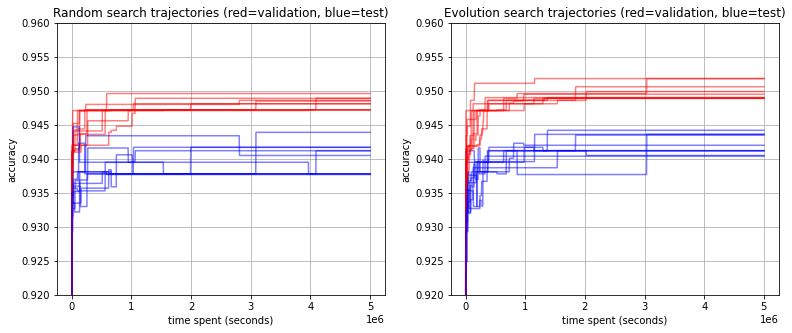

In [20]:

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
for times, best_valid, best_test in random_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Random search trajectories (red=validation, blue=test)')


plt.subplot(1, 3, 2)
for times, best_valid, best_test in evolution_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Evolution search trajectories (red=validation, blue=test)')

In [25]:
mean_best_validation_random = mean([x[1][-1] for x in random_data])
print(mean_best_validation_random)
mean_best_test_random = mean([x[2][-1] for x in random_data])
print(mean_best_test_random)
mean_best_validation_evolution = mean([x[1][-1] for x in evolution_data])
print(mean_best_validation_evolution)
mean_best_test_evolution = mean([x[2][-1] for x in evolution_data])
print(mean_best_test_evolution)

0.9480378669500351
0.9401782751083374
0.9497436028718949
0.94143829703331


In [46]:
len(random_data[20][0])

4132

In [ ]:
# Compare the mean test accuracy along with error bars.
def plot_data(data, color, label, gran=10000, max_budget=5000000):
  """Computes the mean and IQR fixed time steps."""
  xs = range(0, max_budget+1, gran)
  mean = [0.0]
  per25 = [0.0]
  per75 = [0.0]
  
  repeats = len(data)
  pointers = [1 for _ in range(repeats)]
  
  cur = gran
  while cur < max_budget+1:
    all_vals = []
    for repeat in range(repeats):
      while (pointers[repeat] < len(data[repeat][0]) and 
             data[repeat][0][pointers[repeat]] < cur):
        pointers[repeat] += 1
      prev_time = data[repeat][0][pointers[repeat]-1]
      prev_test = data[repeat][2][pointers[repeat]-1]
      next_time = data[repeat][0][pointers[repeat]]
      next_test = data[repeat][2][pointers[repeat]]
      assert prev_time < cur and next_time >= cur

      # Linearly interpolate the test between the two surrounding points
      cur_val = ((cur - prev_time) / (next_time - prev_time)) * (next_test - prev_test) + prev_test
      
      all_vals.append(cur_val)
      
    all_vals = sorted(all_vals)
    mean.append(sum(all_vals) / float(len(all_vals)))
    per25.append(all_vals[int(0.25 * repeats)])
    per75.append(all_vals[int(0.75 * repeats)])
      
    cur += gran
    
  plt.plot(xs, mean, color=color, label=label, linewidth=2)
  plt.fill_between(xs, per25, per75, alpha=0.1, linewidth=0, facecolor=color)

plot_data(random_data, 'red', 'random')
plot_data(evolution_data, 'blue', 'evolution')
plt.legend(loc='lower right')
plt.ylim(0.92, 0.95)
plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()

## More information

For more information on using the dataset, see the API documentation at https://github.com/google-research/nasbench/blob/master/nasbench/api.py.
